In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

In [3]:
os.chdir('/content/drive/MyDrive/Test_case/Figures_detection/detecror_training_2/')
sys.path.append('/content/drive/MyDrive/Test_case/Figures_detection')
sys.path.append('/content/drive/MyDrive/Test_case')

# Imports setup

In [4]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as F
from tqdm import tqdm
from utils.loss import lossYolov1
from yolov_1_model import YOLO_model
from detecror_training_2.utils.metrics import *
from detecror_training_2.utils.utils import save_checkpoint, load_checkpoint, update_dataset_info
from detecror_training_2.utils.dataloaders import get_loaders, ShapeDatasetFromGenerator
import pandas as pd
import pickle
from torch.utils.data import DataLoader




In [5]:
with open('runs/train/train_meta_0_v1.pth.tar.pickle', 'rb') as f:
    data = pickle.load(f)
print(data)

{'n_images': 1024, 'n_img_per_class_epoch': {0: 614, 1: 594, 2: 577, 3: 600}}


In [6]:
with open('runs/train/train_meta_1_v1.pth.tar.pickle', 'rb') as f:
    data = pickle.load(f)
print(data)

{'n_images': 1024, 'n_img_per_class_epoch': {0: 612, 1: 615, 2: 587, 3: 612}}


In [7]:
with open('runs/train/train_meta_2_v1.pth.tar.pickle', 'rb') as f:
    data = pickle.load(f)
print(data)

{'n_images': 1024, 'n_img_per_class_epoch': {0: 590, 1: 624, 2: 614, 3: 586}}


In [5]:

EPOCHS = 3 # 16
TEST_SIZE_DATA = 64
TRAIN_SIZE_DATA = 64
BATCH_SIZE = 16
LEARN_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
WEIGHT_DECAY = 0
CHECK_PATH = './checkpoints'
RESIZE_SHAPE = 256
MODEL_VERSION = "v1" + ".pth.tar"
TEST_RUNS_RES = './runs/test'
TRAIN_RUNS_RES = './runs/train'
LABEL_DIR = './dataset_batches_generated'

SUB_EPOCH = 16 # == [ reqired_epoch_size / len__annotations ] = 16

# Base classes and functions

In [6]:

class Compose(object):
    def __init__(self, tfs):
        self.tfs = tfs

    def __call__(self, img, bboxes):
        for t in self.tfs:
            img, bbox = t(img), bboxes
        return img, bbox



def get_iou(true_boxes, pred_boxes, n_classes = 4):
    iou_list = []
    for c in range(n_classes):
        detections = []
        ground_truths = []
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)
        detections.sort(key=lambda x: x[2], reverse=True)
        total_true_bboxes = len(ground_truths)

        # print("total_true_bboxes = ", total_true_bboxes)
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format="midpoint",
                )
                iou_list.append(iou.item())

    return iou_list

def inference(model, loader, epoch, save_image_detected_res = None, save_dataframe_path = None,  img_label = '', test_inference_times = 1):
    iou_per_batch = []

    # iterate through __len__ annotations in DataLoadeers
    # in order to get 1000 images for inference testing we should run get_bboxes() n times
    # n = 1000 // TEST_SIZE_DATA = 1000 / 24 = 42 times
    # ### FOR TEST INFERENCE
    mean_iou, max_iou, min_iou, recall, precision, maP = 0, 0, 0, 0, 0, 0

    for i in range(test_inference_times):
        all_pred_boxes, all_true_boxes = get_bboxes( loader = loader, model = model,iou_threshold = 0.4,\
                     threshold = 0.4, save_image_detected_res=save_image_detected_res,\
                                   epoch =  epoch , inference_time = i, img_label = img_label)

        true_boxes = torch.Tensor(all_true_boxes)
        pred_boxes =  torch.Tensor(all_pred_boxes)
        iou_list = get_iou(all_true_boxes, all_pred_boxes)

        # GET BASE METRICS
        mean_iou += np.mean(iou_list) / test_inference_times
        max_iou += max(iou_list, default=0) / test_inference_times
        min_iou += min(iou_list, default=0) / test_inference_times

        mAPrecision, precisions_list, recall_list = mean_average_precision(all_pred_boxes, \
                 all_true_boxes, iou_threshold=0.4, get_prec_rec = True)
        mAPrecision += mAPrecision.item() / test_inference_times
        recall += np.mean(recall_list) / test_inference_times
        precision += np.mean(precisions_list) / test_inference_times


    df = pd.DataFrame(data={
        "MODEL_VERSION" : MODEL_VERSION,
        "epoch": epoch,
        "mean_iou" : mean_iou ,
        "max_iou": max_iou,
        "min_iou": min_iou,
        "precision": precision ,
        "recall": recall,
        "mAP.0.5" : mAPrecision
    },  index=[0])

    with pd.option_context('display.max_rows', 100,
                           'display.max_columns', 20,
                           'display.precision', 5
                           ):
        print(df)
    if save_dataframe_path is not None:
        df.to_csv(save_dataframe_path + f'/metrics_{img_label}_{MODEL_VERSION}__{epoch}.csv')



In [7]:

def train_function(yolo_model, train_loader, optimizer, loss_fn , model_version, load_check, last_loss, epoch):
    loss_per_train = []

    yolo_model = yolo_model.to(DEVICE)
    n_images = 0 # per all epoch
    n_img_per_class_epoch = {
        0: 0, #  triangle
        1: 0, # hex
        2: 0, # circle
        3: 0, # rombus

    }

    for i in range(SUB_EPOCH):

        for k, (x, y) in enumerate(train_loader):
            n_images += (len(x))
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = yolo_model(x)
            loss = loss_fn(preds, y)
            loss_per_train.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"\n____ SUB_EPOCH = {i}, loss for batches = {np.mean(loss_per_train)} ____ \n")
        n_img_per_class_epoch = update_dataset_info(path_annotations = LABEL_DIR + '/annotations_txt', dict_to_update=n_img_per_class_epoch)

        # re-save best checkpoint:
        if np.mean(loss_per_train) < last_loss:
            last_loss = np.mean(loss_per_train)
            # do save
            save_checkpoint(epoch = epoch, model = yolo_model, optimizer = optimizer, LOSS = last_loss,\
                 path = CHECK_PATH, filename=f"/yolo_e{epoch}_best_" + MODEL_VERSION )
        # run inference
        print(f"#  INFERENCE during training sub_epoch = {i}...   #   ")
        inference(yolo_model, train_loader, epoch, save_dataframe_path=TEST_RUNS_RES, \
                      save_image_detected_res=TEST_RUNS_RES, img_label = f"inference_train_ep_{epoch}_{i}")


    print("\n## mean TRAIN LOSS EPOCH ## = ", np.mean(loss_per_train) )
    return np.mean(loss_per_train) , n_img_per_class_epoch , n_images

def save_metainfo(n_img_per_class_epoch , n_images, epoch, MODEL_VERSION):
    info = {
        "n_images" : n_images,
        "n_img_per_class_epoch" : n_img_per_class_epoch
    }
    with open(TRAIN_RUNS_RES + f'/train_meta_{epoch}_{MODEL_VERSION}.pickle', 'wb') as handle:
        pickle.dump(info, handle)


In [8]:
from torch.optim.lr_scheduler import ExponentialLR

def run(save_dataframe_path=TEST_RUNS_RES, load_check = ''):
    tfs = Compose([transforms.Resize((RESIZE_SHAPE, RESIZE_SHAPE)), transforms.ToTensor()])

    model = YOLO_model(patch_size=4, n_boxes_per_img = 2, input_img_width = 256, n_classes = 4)
    train_loader, test_loader = get_loaders(tfs, BATCH_SIZE,  TRAIN_SIZE_DATA, TEST_SIZE_DATA)
    loss_fn = lossYolov1()
    opt = optim.Adam(model.parameters(), lr=LEARN_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = ExponentialLR(opt, gamma=0.9)
    loss_per_epoch = []
    model = model.to(DEVICE)
    try:
        model, opt = load_checkpoint(checkpoint_path= load_check, model=model, optimizer=opt)
        print("LOADED WEIGHTS")
    except:
        print("\n====================\n  looks like we gonna train from scratch  \n======================")

    avg_train_loss = 2e12
    for epoch in range(EPOCHS):
        print(f"######################### EPOCH = {epoch}")

        avg_train_loss , n_img_per_class_epoch , n_images = train_function(yolo_model=model, train_loader = train_loader, \
                           optimizer = opt, loss_fn = loss_fn, model_version = MODEL_VERSION, \
                                                        load_check=load_check, last_loss = avg_train_loss, epoch =epoch)

        loss_per_epoch.append(avg_train_loss)

        save_losses(loss_per_epoch, MODEL_VERSION)

        save_metainfo(n_img_per_class_epoch , n_images, epoch, MODEL_VERSION)
        if epoch >= 3:
            scheduler.step()

        if  epoch == EPOCHS-1 :
            # do save
            save_checkpoint(epoch = epoch, model = model, optimizer = opt, LOSS = avg_train_loss,\
                 path = CHECK_PATH, filename=f"/yolo_last_" + MODEL_VERSION )






# Run train

### Run

=> Loaded checkpoint
LOADED WEIGHTS
######################### EPOCH = 0

____ SUB_EPOCH = 0, loss for batches = 167.58570098876953 ____ 

=> Saving checkpoint. LOSS =  167.58570098876953
#  INFERENCE during training sub_epoch = 0...   #   
  MODEL_VERSION  epoch  mean_iou  max_iou  min_iou  precision  recall  \
0    v1.pth.tar      0   0.00499  0.09777      0.0        0.0     0.0   

      mAP.0.5  
0  tensor(0.)  

____ SUB_EPOCH = 1, loss for batches = 170.71366500854492 ____ 

#  INFERENCE during training sub_epoch = 1...   #   
  MODEL_VERSION  epoch  mean_iou  max_iou  min_iou  precision  recall  \
0    v1.pth.tar      0   0.01361  0.32963      0.0        0.0     0.0   

      mAP.0.5  
0  tensor(0.)  

____ SUB_EPOCH = 2, loss for batches = 172.9350153605143 ____ 

#  INFERENCE during training sub_epoch = 2...   #   
  MODEL_VERSION  epoch  mean_iou  max_iou  min_iou  precision   recall  \
0    v1.pth.tar      0   0.02294  0.69084      0.0    0.00191  0.00667   

              mA

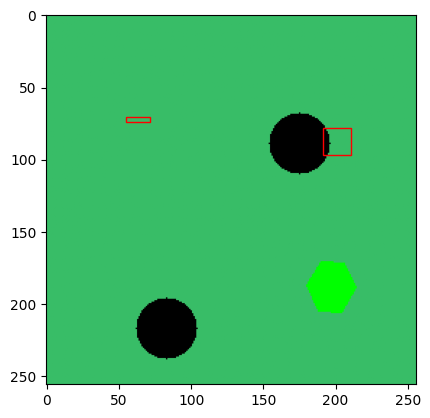

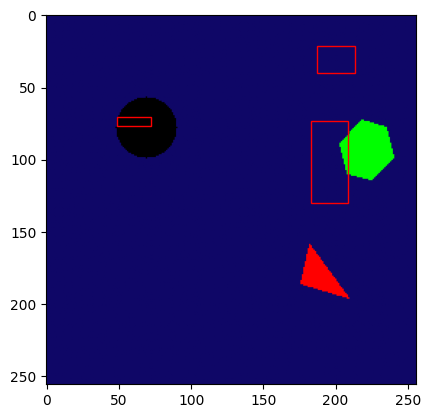

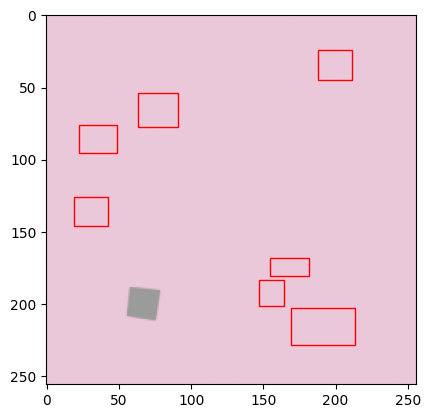

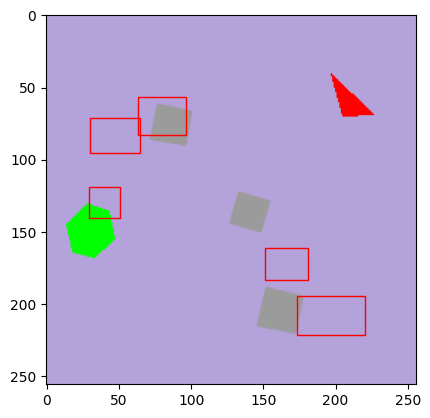

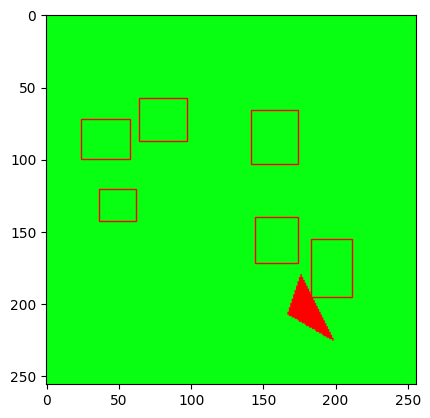

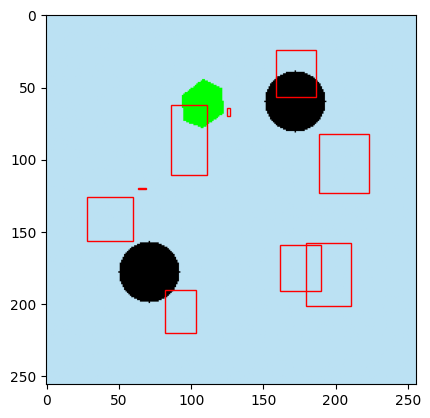

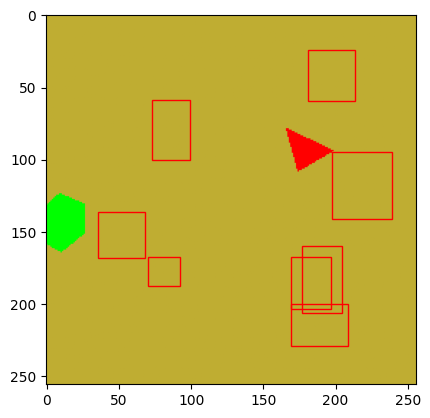

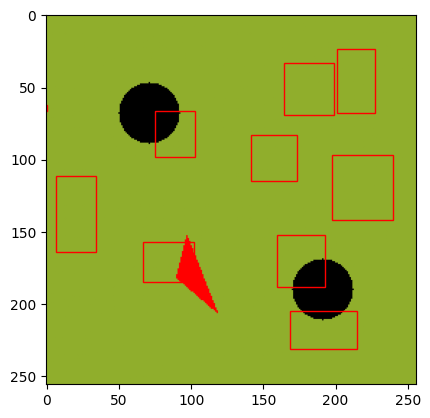

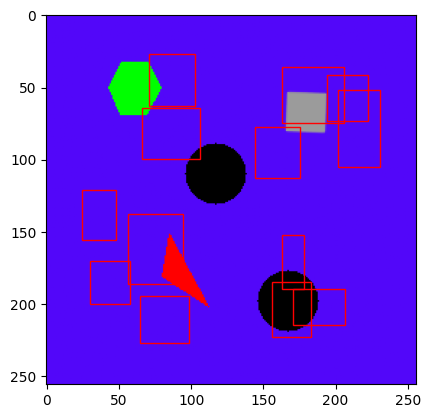

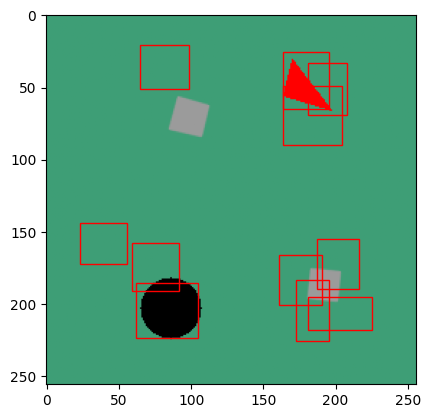

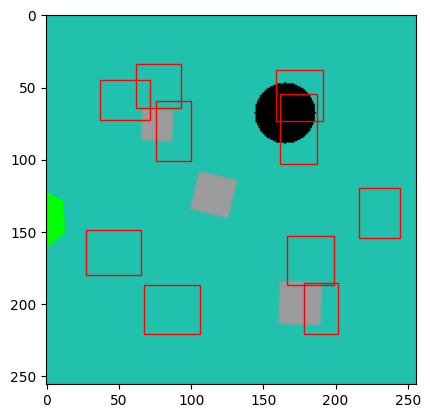

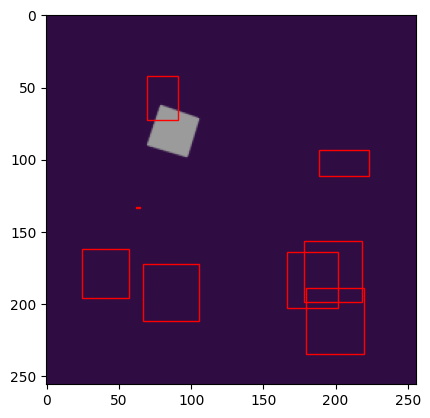

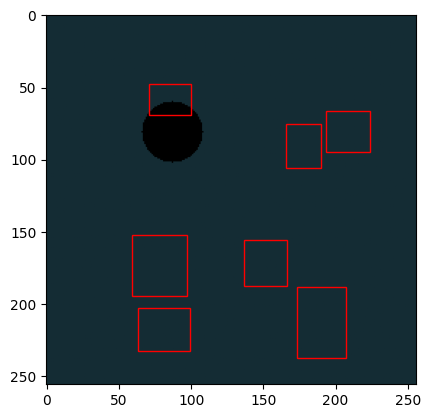

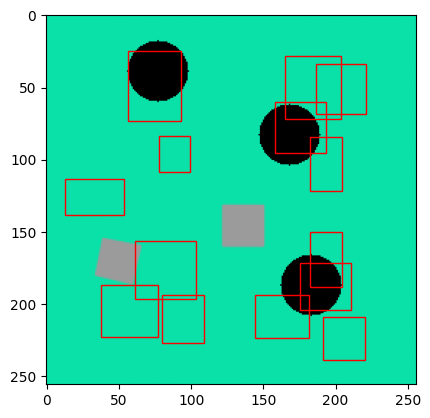

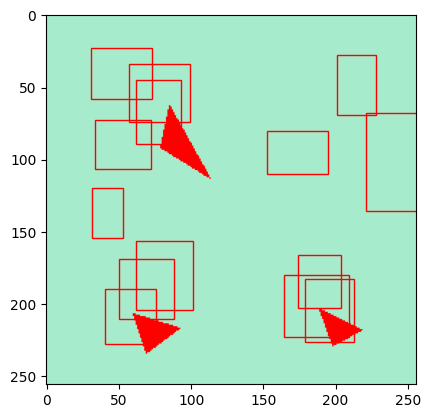

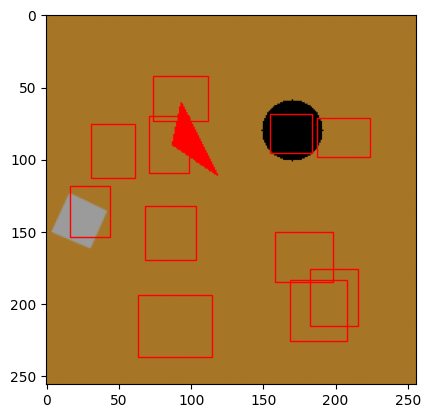

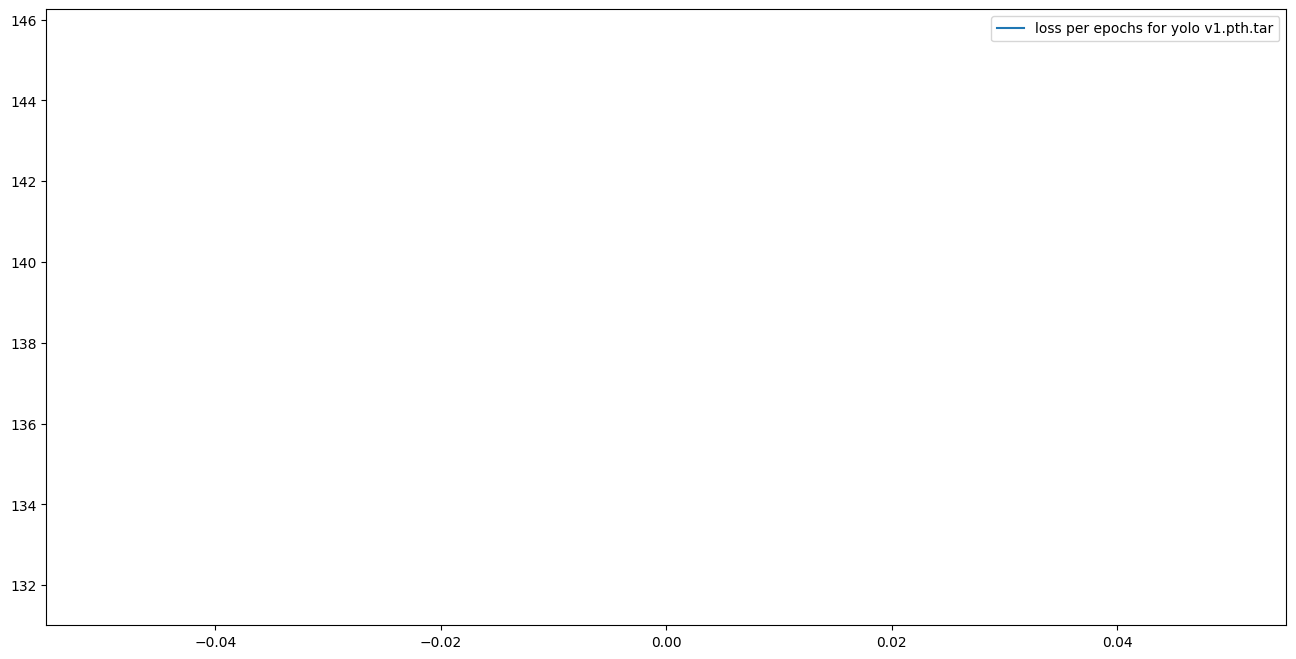

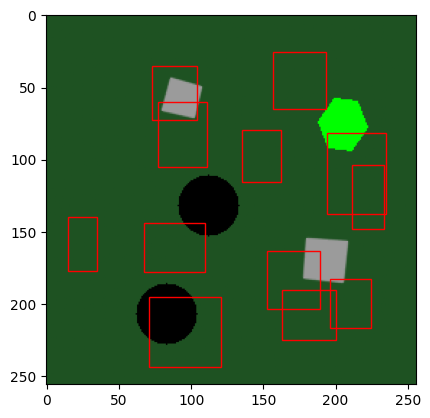

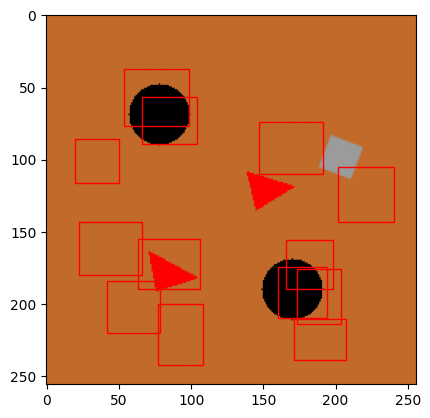

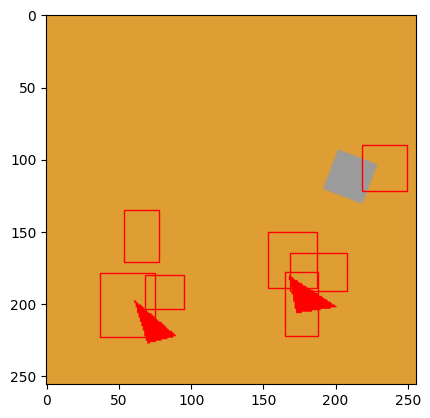

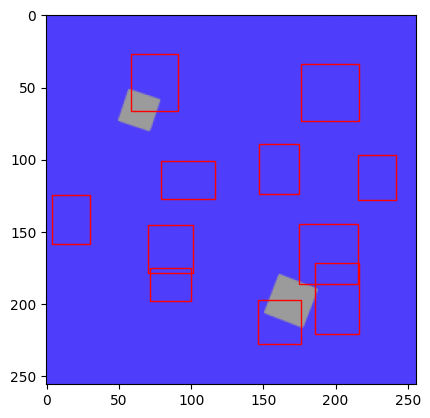

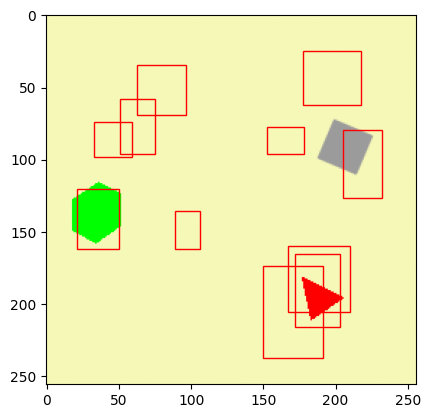

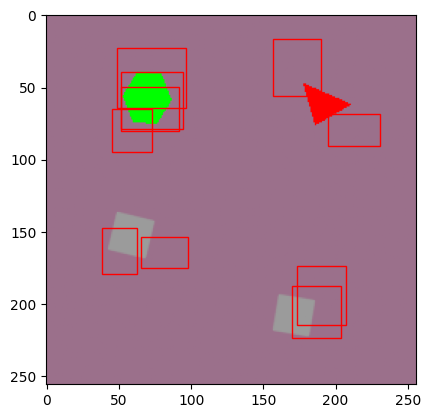

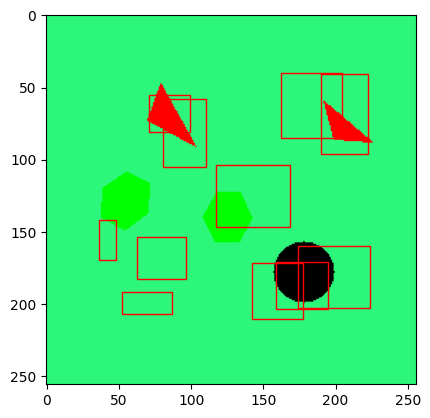

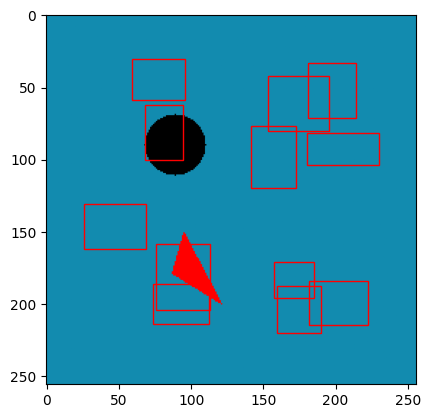

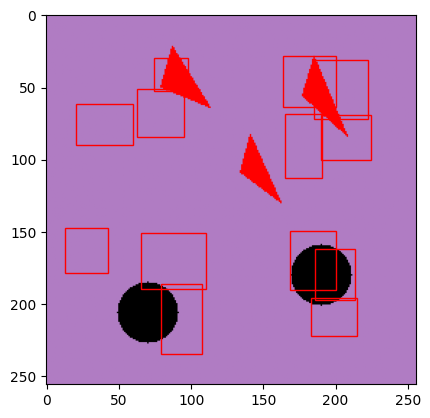

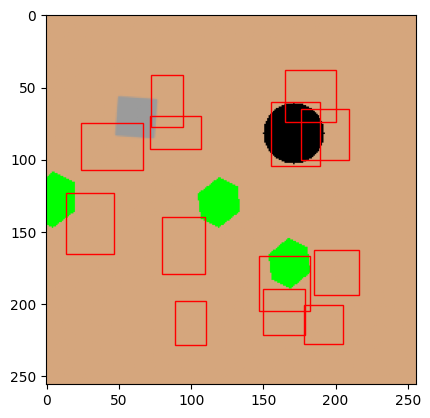

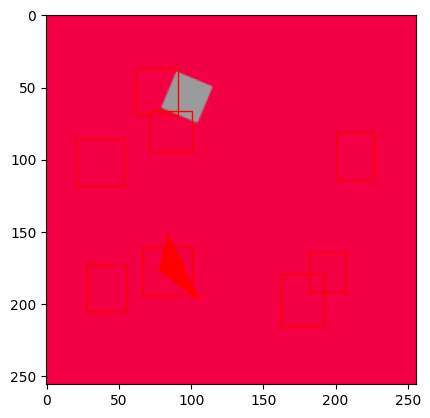

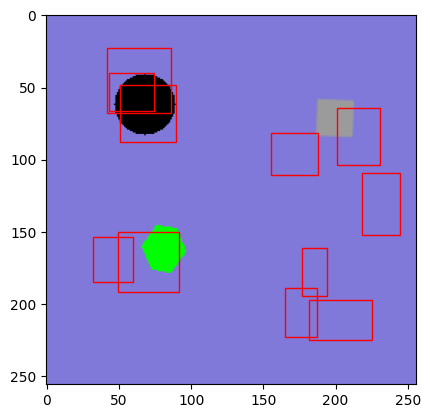

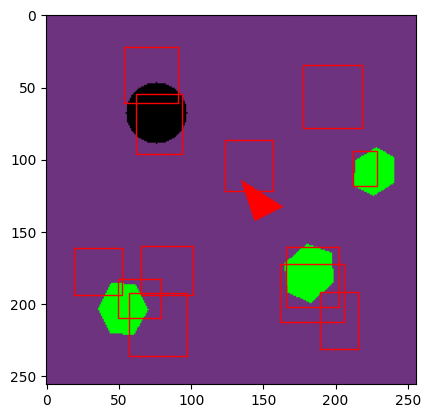

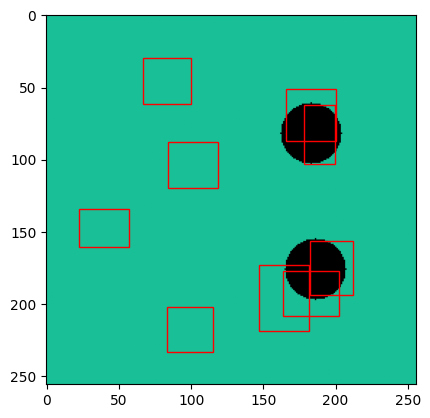

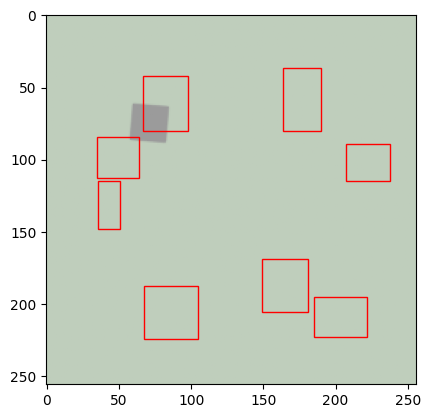

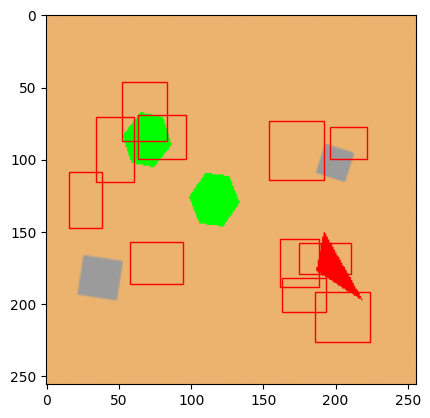

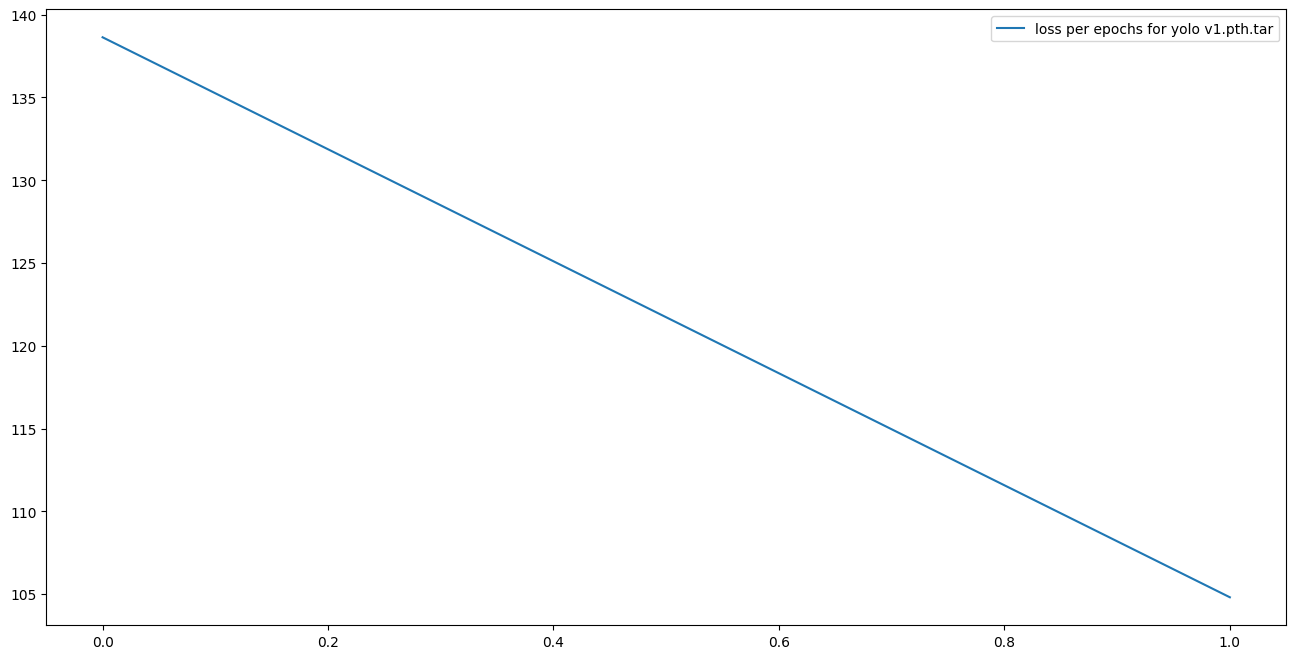

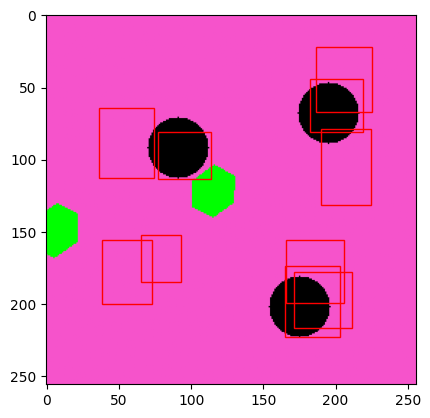

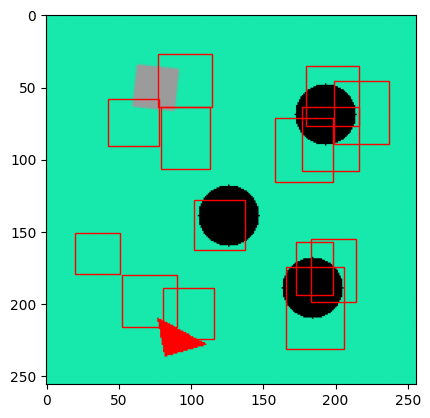

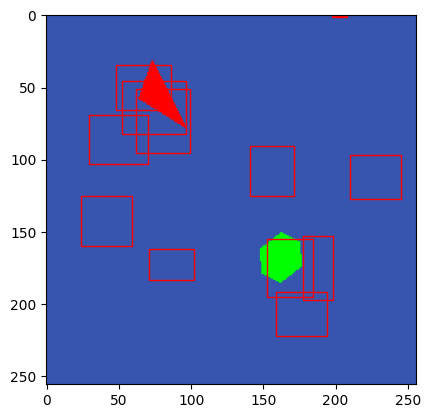

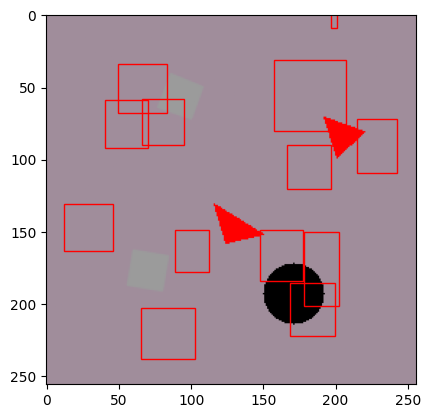

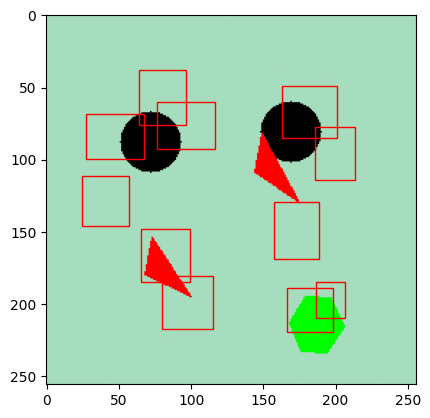

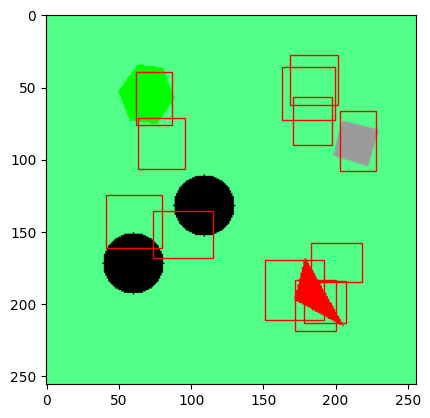

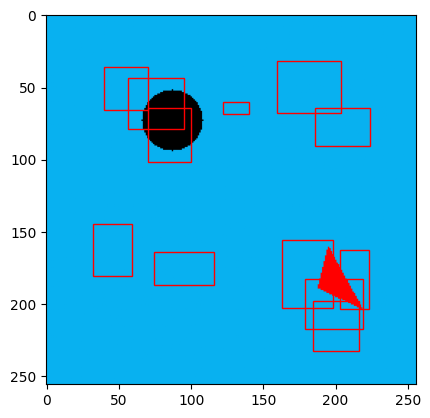

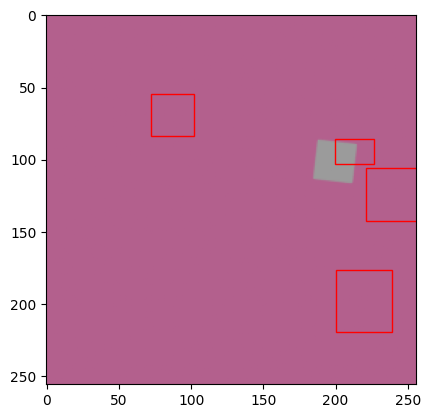

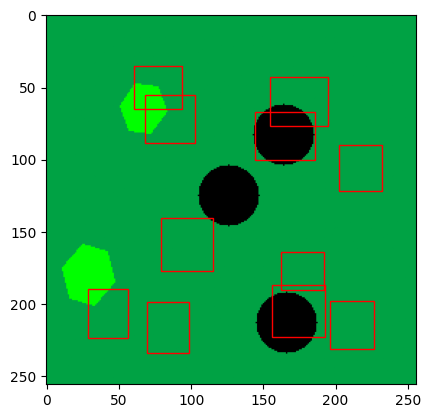

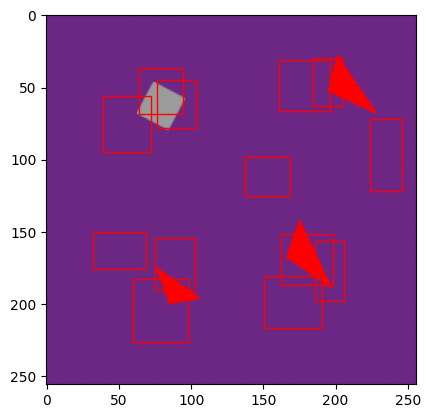

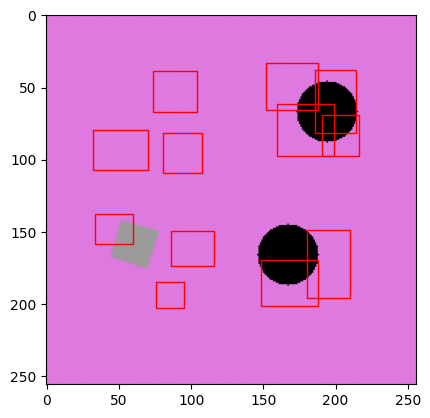

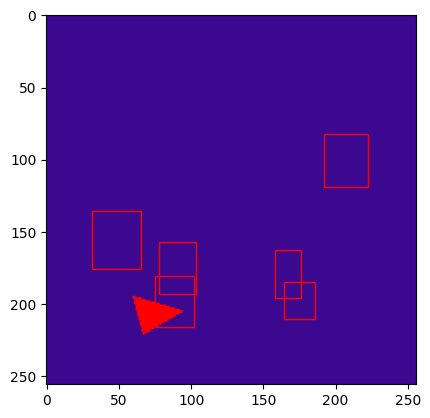

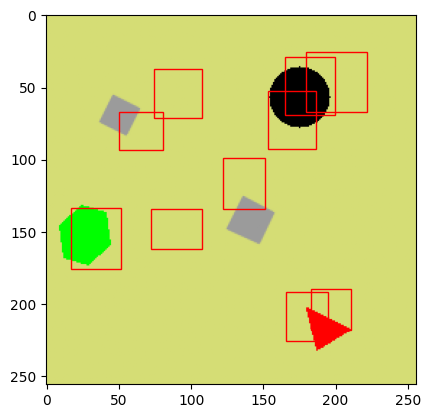

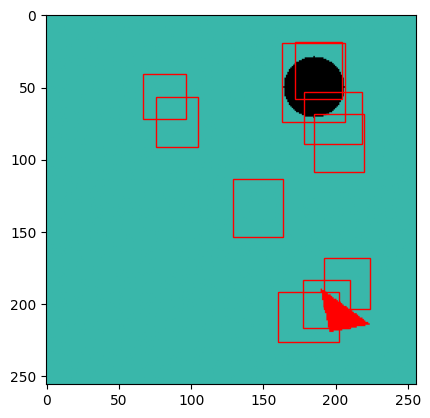

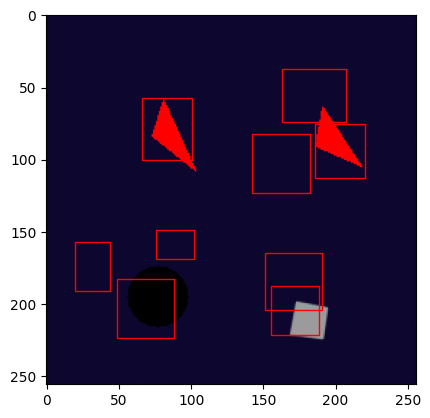

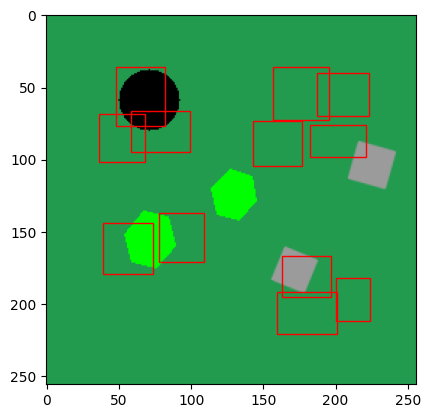

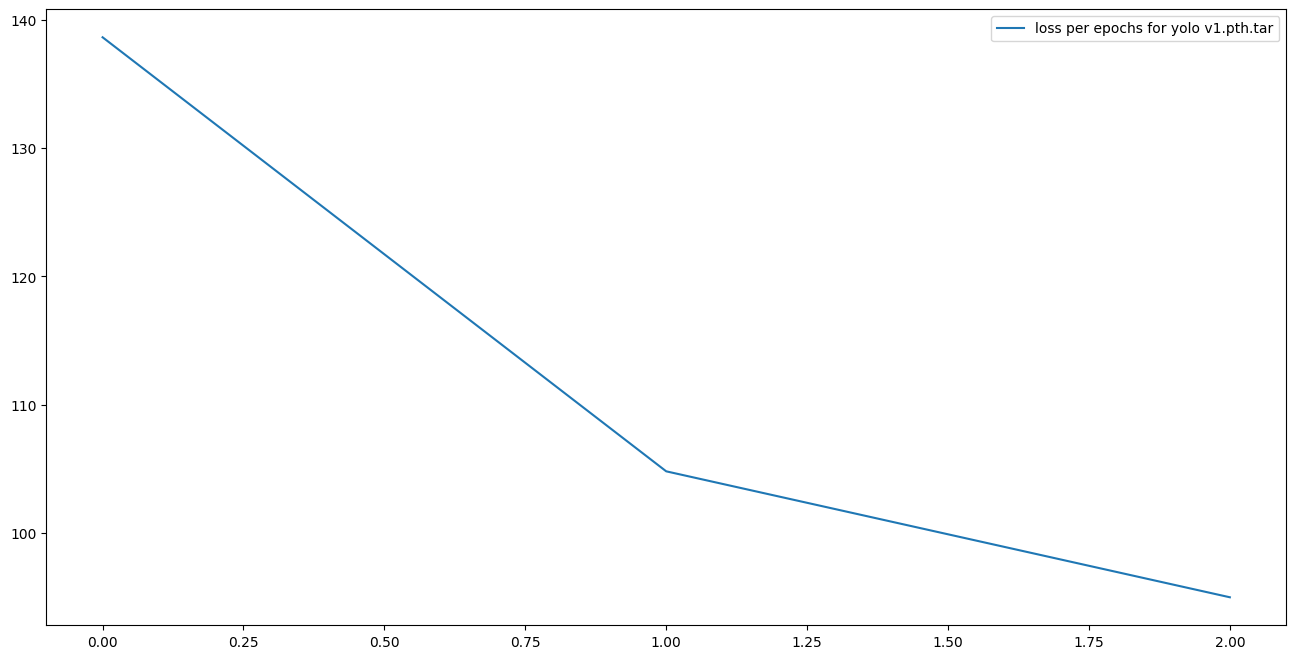

In [11]:
# run(load_check = 'checkpoints/yolo_e0_best_v1.pth.tar' )
# threshold = 0.12 during training

# Test best and last checkpoint

In [9]:
BEST_CHECKPOINT = 'checkpoints/yolo_e2_best_v1.pth.tar'
LAST_CHECPOINT = 'checkpoints/yolo_last_v1.pth.tar'

## Test best

In [ ]:
TEST_SIZE_DATA = 64

tfs = Compose([transforms.Resize((RESIZE_SHAPE, RESIZE_SHAPE)), transforms.ToTensor()])
model_BEST = YOLO_model(patch_size=4, n_boxes_per_img = 2, input_img_width = 256, n_classes = 4)
train_loader, test_loader = get_loaders(tfs, BATCH_SIZE,  TRAIN_SIZE_DATA, TEST_SIZE_DATA)
loss_fn = lossYolov1()
opt = optim.Adam(model_BEST.parameters(), lr=LEARN_RATE, weight_decay=WEIGHT_DECAY)
loss_per_epoch = []
model_BEST = model_BEST.to(DEVICE)

model_BEST, opt = load_checkpoint(checkpoint_path= BEST_CHECKPOINT, model=model_BEST, optimizer=opt)

KeyboardInterrupt: ignored

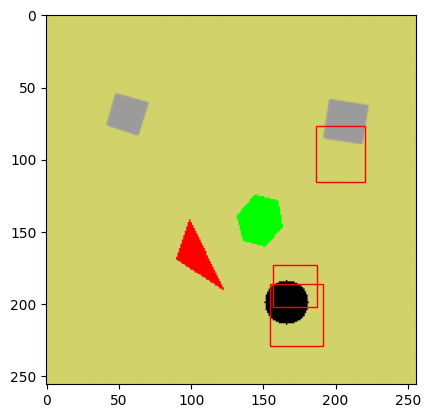

In [45]:
inference(model_BEST, test_loader, epoch = 1, save_dataframe_path=TEST_RUNS_RES, \
              save_image_detected_res=TEST_RUNS_RES, img_label = f"infer_test_BEST", test_inference_times = 1)


In [38]:
res_best = pd.read_csv('runs/test/metrics_infer_test_BEST_v1.pth.tar__1.csv')

In [40]:
res_best.to_excel('test_best_1024.xlsx')

## Tets last

In [11]:
TEST_SIZE_DATA = 64
tfs = Compose([transforms.Resize((RESIZE_SHAPE, RESIZE_SHAPE)), transforms.ToTensor()])
model_LAST = YOLO_model(patch_size=4, n_boxes_per_img = 2, input_img_width = 256, n_classes = 4)
train_loader, test_loader = get_loaders(tfs, BATCH_SIZE,  TRAIN_SIZE_DATA, TEST_SIZE_DATA)
loss_fn = lossYolov1()
opt = optim.Adam(model_LAST.parameters(), lr=LEARN_RATE, weight_decay=WEIGHT_DECAY)
loss_per_epoch = []
model_LAST = model_LAST.to(DEVICE)

model_LAST, opt = load_checkpoint(checkpoint_path= LAST_CHECPOINT, model=model_LAST, optimizer=opt)

=> Loaded checkpoint


  MODEL_VERSION  epoch  mean_iou  max_iou  min_iou  precision   recall  \
0    v1.pth.tar      1   0.14573  0.82987      0.0    0.22635  0.11576   

          mAP.0.5  
0  tensor(0.1535)  


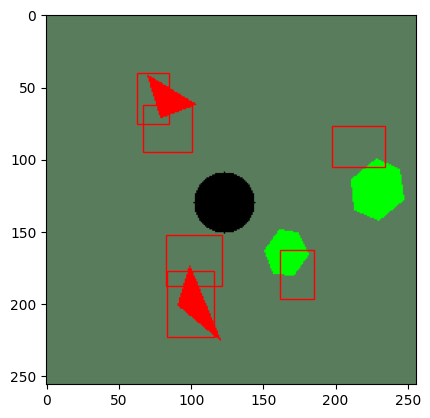

In [12]:
inference(model_LAST, test_loader, epoch = 1, save_dataframe_path=TEST_RUNS_RES, \
              save_image_detected_res=TEST_RUNS_RES, img_label = f"infer_test_LAST", test_inference_times = 1)


In [14]:
res_LAST = pd.read_csv('runs/test/metrics_infer_test_LAST_v1.pth.tar__1.csv')

In [15]:
res_LAST.to_excel('test_last_1024.xlsx')

### Collect training results

{'n_images': 1024, 'n_img_per_class_epoch': {0: 614, 1: 594, 2: 577, 3: 600}}


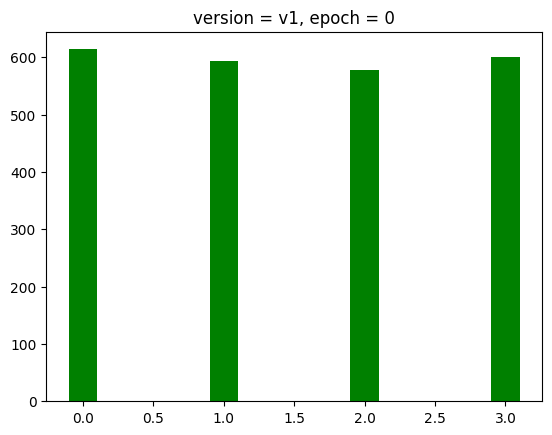

{'n_images': 1024, 'n_img_per_class_epoch': {0: 612, 1: 615, 2: 587, 3: 612}}


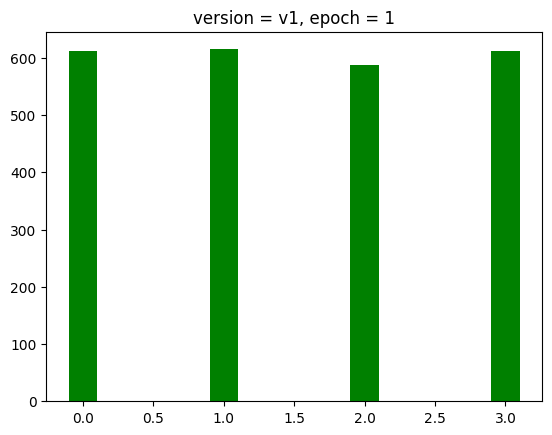

{'n_images': 1024, 'n_img_per_class_epoch': {0: 590, 1: 624, 2: 614, 3: 586}}


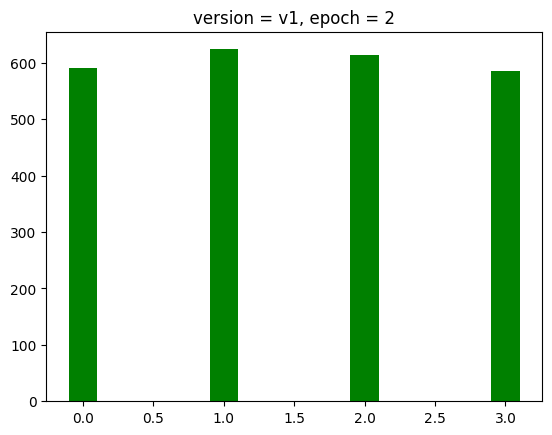

In [15]:
path_data_metaino = './runs/train/'

for info in os.listdir(path_data_metaino):
    with open(path_data_metaino + info, 'rb') as f:
        data = pickle.load(f)
        print(data)
        version = info.split('.')[0][-2:]
        epoch = info.split('.')[0][-4:-3]
        plt.bar(list(data['n_img_per_class_epoch'].keys()),\
                data['n_img_per_class_epoch'].values(),  color='g', width = 0.2)
        plt.title(f"version = {version}, epoch = {epoch}")
        plt.show()


In [12]:
# 1 epoch
path_data_metaino = './runs/test/'


df = pd.DataFrame()
for i in range(0, 16):
    info = f'metrics_inference_train_ep_2_{i}_v1.pth.tar__2.csv'
    df_ = pd.read_csv(path_data_metaino + info)
    df_['sub_epoch'] = i
    df = pd.concat([df_, df], axis = 0)



for i in range(0, 16):
    info = f'metrics_inference_train_ep_0_{i}_v1.pth.tar__0.csv'
    df_ = pd.read_csv(path_data_metaino + info)
    df_['sub_epoch'] = i
    df = pd.concat([df_, df], axis = 0)


for i in range(0, 16):
    info = f'metrics_inference_train_ep_1_{i}_v1.pth.tar__1.csv'
    df_ = pd.read_csv(path_data_metaino + info)
    df_['sub_epoch'] = i
    df = pd.concat([df_, df], axis = 0)



In [13]:
df = df.drop(columns = ['Unnamed: 0']).sort_values(['epoch', 'sub_epoch']).reset_index()

In [14]:
from matplotlib import pyplot as plt
df

,index,MODEL_VERSION,epoch,mean_iou,max_iou,min_iou,precision,recall,mAP.0.5,sub_epoch
0,0,v1.pth.tar,0,0.004986,0.097768,0.0,0.000000,0.000000,tensor(0.),0
1,0,v1.pth.tar,0,0.013610,0.329634,0.0,0.000000,0.000000,tensor(0.),1
2,0,v1.pth.tar,0,0.022940,0.690839,0.0,0.001915,0.006674,tensor(8.1110e-05),2
3,0,v1.pth.tar,0,0.039442,0.643538,0.0,0.005625,0.009268,tensor(0.0015),3
4,0,v1.pth.tar,0,0.024423,0.558163,0.0,0.003423,0.006592,tensor(0.0007),4
5,0,v1.pth.tar,0,0.029416,0.725001,0.0,0.008648,0.020852,tensor(0.0016),5
6,0,v1.pth.tar,0,0.038135,0.689135,0.0,0.071722,0.052083,tensor(0.0213),6
7,0,v1.pth.tar,0,0.037104,0.657986,0.0,0.040213,0.045469,tensor(0.0062),7
8,0,v1.pth.tar,0,0.041401,0.729092,0.0,0.040784,0.053750,tensor(0.0080),8
9,0,v1.pth.tar,0,0.042013,0.622215,0.0,0.022911,0.038449,tensor(0.0072),9


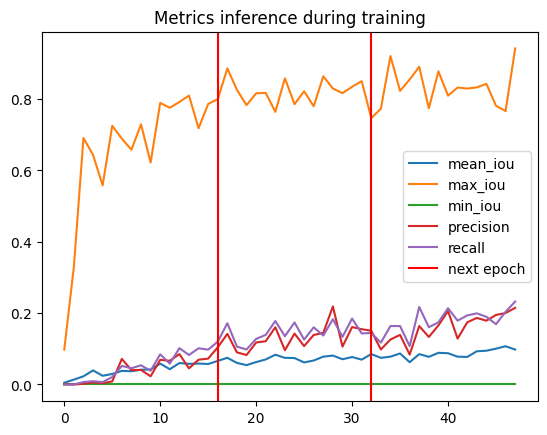

In [17]:
for i in ['mean_iou', 'max_iou', 'min_iou',
       'precision', 'recall'] :
    plt.plot(df[[i]], label = i)


plt.axvline(16, color = 'red', label = 'next epoch')
plt.axvline(32, color = 'red')
plt.title("Metrics inference during training")
plt.legend()